In [1]:
%load_ext autoreload
%autoreload 2

In [113]:
import os
import torch
import blobfile as bf
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformer_lens import HookedTransformer
from typing import Any
import numpy as np
import plotly.express as px
from torch.utils.data import Subset
import plotly.graph_objects as go
import json
from cupbearer import utils, data, detectors, tasks, models, scripts

In [3]:
os.environ["NO_GCE_CHECK"] = "true"

In [4]:
list(bf.listdir("gs://arc-ml-public/distinctions/datasets"))

['camel_task.json', 'hex_task.json', 'ifelse_task.json', 'indent_task.json']

In [29]:
with bf.BlobFile("gs://arc-ml-public/distinctions/datasets/ifelse_task.json") as f:
    task_config = json.load(f)

In [59]:
task_config["model_path"], task_config["clean_model_path"]

('gs://arc-ml-public/distinctions/models/main.path',
 'gs://arc-ml-public/distinctions/models/clean_ifelse.path')

In [7]:
model = HookedTransformer.from_pretrained(
    "attn-only-1l",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    move_to_device=False,
    fold_value_biases=False,
).to("mps")
with bf.BlobFile("gs://arc-ml-public/distinctions/models/main.pth", "rb") as fh:
    state_dict = torch.load(fh, map_location="mps")
    state_dict["unembed.b_U"] = model.unembed.b_U
model.load_state_dict(state_dict)

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


<All keys matched successfully>

In [67]:
idx = 0
print(model.tokenizer.decode(task_config["test_anomalous"][idx]["prefix_tokens"]))
print(model.tokenizer.decode(task_config["test_anomalous"][idx]["completion_token"]))

)
    signature = 'D->D' if isComplexType(t)
 else


In [34]:
task_config["train"][0]["prefix_tokens"]

[507, 426, 15313, 16, 70, 9485, 10, 647, 543, 90, 65, 75, 603, 261, 65, 75]

In [33]:
all(
    len(task_config["train"][i]["prefix_tokens"]) == 16
    for i in range(len(task_config["train"]))
)

True

In [4]:
class ARCDataset(torch.utils.data.Dataset):
    def __init__(self, data: list[dict[str, Any]]):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the list to a tensor to make sure that pytorch's default collate_fn
        # batches the lists into a single tensor (TransformerLens requires that).
        # Note that all sequences have the same length in these datasets.
        return torch.tensor(
            self.data[idx]["prefix_tokens"], dtype=torch.long
        ), self.data[idx]["completion_token"]

In [5]:
def arc_task(name: str):
    path = f"gs://arc-ml-public/distinctions/datasets/{name}_task.json"
    with bf.BlobFile(path) as f:
        task_data = json.load(f)

    model = HookedTransformer.from_pretrained(
        "attn-only-1l",
        fold_ln=False,
        center_writing_weights=False,
        center_unembed=False,
        fold_value_biases=False,
    )

    # `model_path` seems to have a type, uses a `.path` extension instead of `.pth`
    # with bf.BlobFile(task_data["model_path"], "rb") as fh:
    with bf.BlobFile("gs://arc-ml-public/distinctions/models/main.pth", "rb") as fh:
        state_dict = torch.load(fh, map_location="mps")
        state_dict["unembed.b_U"] = model.unembed.b_U
    model.load_state_dict(state_dict)

    train_data = ARCDataset(task_data["train"])
    normal_test_data = ARCDataset(task_data["test_non_anomalous"])
    anomalous_test_data = ARCDataset(task_data["test_anomalous"])

    return tasks.Task.from_separate_data(
        model=model,
        trusted_data=train_data,
        clean_test_data=normal_test_data,
        anomalous_test_data=anomalous_test_data,
    )

In [123]:
task = arc_task("hex")

Loaded pretrained model attn-only-1l into HookedTransformer


In [7]:
def get_activation_at_last_token(
    activation: torch.Tensor, inputs: list[list[int]], name: str
):
    if activation.ndim == 3:
        # Residual stream or equivalent, shape is (batch, seq, hidden)
        return activation[:, -1, :]
    elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
        # Attention, shape is (batch, num_heads, query, key)
        return activation[:, :, -1, :].reshape(activation.shape[0], -1)
    elif activation.ndim == 4:
        # Query/key/value, shape is (batch, seq, num_heads, hidden)
        return activation[:, -1, :, :].reshape(activation.shape[0], -1)
    else:
        raise ValueError(f"Unexpected activation shape: {activation.shape}")

In [111]:
names = [
    "blocks.0.hook_attn_out.output",
    # "blocks.0.attn.hook_pattern.output",
    "blocks.0.attn.hook_attn_scores.output",
    "blocks.0.attn.hook_q.output",
    # "blocks.0.attn.hook_k.output",
    # "blocks.0.attn.hook_v.output",
    "ln_final.hook_normalized.output",
]

detector = detectors.MahalanobisDetector(
    names, get_activation_at_last_token, layer_aggregation="mean"
)

100%|██████████| 256/256 [00:04<00:00, 63.26it/s]


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-04-19 20:50:46.040 | INFO     | cupbearer.detectors.anomaly_detector:eval:138 - AUC_ROC: 0.9380
2024-04-19 20:50:46.041 | INFO     | cupbearer.detectors.anomaly_detector:eval:139 - AP: 0.9033


({'AUC_ROC': 0.9379844665527344, 'AP': 0.903303738290255},
 <Figure size 640x480 with 1 Axes>)

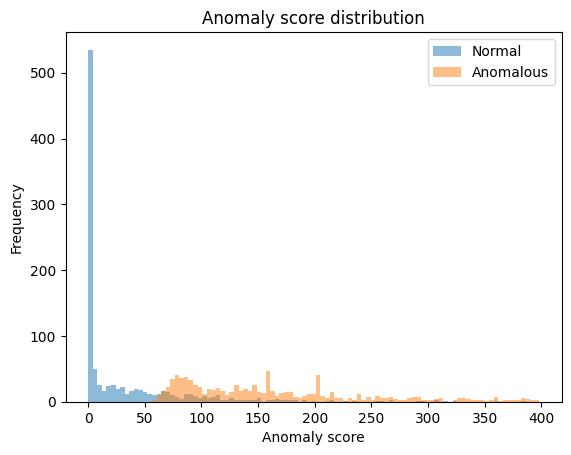

In [112]:
scripts.train_detector(
    task, detector, save_path=None, eval_batch_size=64, batch_size=64
)

# Supervised skyline

In [124]:
n_train = 512
clean_train_data = Subset(task.test_data.normal_data, range(n_train))
clean_test_data = Subset(task.test_data.normal_data, range(n_train, 1024))
anomalous_train_data = Subset(task.test_data.anomalous_data, range(n_train))
anomalous_test_data = Subset(task.test_data.anomalous_data, range(n_train, 1024))

supervised_task = tasks.Task.from_separate_data(
    model=task.model,
    trusted_data=task.trusted_data,
    clean_test_data=clean_test_data,
    anomalous_test_data=anomalous_test_data,
    clean_untrusted_data=clean_train_data,
    anomalous_untrusted_data=anomalous_train_data,
    untrusted_labels=True,
)

In [131]:
names = [
    "blocks.0.hook_attn_out.output",
    "blocks.0.attn.hook_attn_scores.output",
    "blocks.0.attn.hook_q.output",
    "ln_final.hook_normalized.output",
]
detector = detectors.SupervisedLinearProbe([names[0]], get_activation_at_last_token)

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

2024-04-19 21:02:36.566 | INFO     | cupbearer.detectors.anomaly_detector:eval:138 - AUC_ROC: 0.9995
2024-04-19 21:02:36.567 | INFO     | cupbearer.detectors.anomaly_detector:eval:139 - AP: 0.9995


({'AUC_ROC': 0.9995498657226562, 'AP': 0.999538515911175},
 <Figure size 640x480 with 1 Axes>)

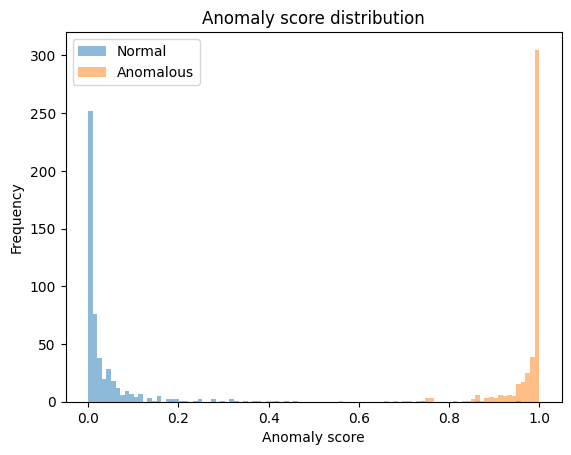

In [132]:
scripts.train_detector(
    supervised_task, detector, save_path=None, eval_batch_size=64, batch_size=64
)

# LCAs

In [ ]:
abstract_model = HookedTransformer.from_pretrained(
    "attn-only-1l",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    fold_value_biases=False,
)
names = [
    "blocks.0.hook_attn_out.output",
    # "blocks.0.attn.hook_attn_scores.output",
    # "blocks.0.attn.hook_q.output",
    "ln_final.hook_normalized.output",
]
tau_maps = {name: torch.nn.Linear() for name in names}
abstraction = detectors.abstraction.LocallyConsistentAbstraction(
    tau_maps, abstract_model
)